In [ ]:
import pandas as pd
import os
from scipy.fft import fft
from scipy.signal import savgol_filter, correlate
from scipy.signal.windows import hann
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from sktime.dists_kernels.dtw import DtwDist
from tqdm import tqdm

In [ ]:
# read in the data
sensor = 'u2' # ankle sensor

class DataPoint():
    templateTimes : str
    template : str
    test : str

# Walk directories and accumulate all data that is under e1/u2 folders
template = []
test = []
templateTimes = {} # name + (time, data)
for root, dirs, files in os.walk('.'):
    for file in files:
        if "template_times.txt" in file and root not in templateTimes:
            tt = os.path.join(root, file)
            templateTimes[root] = tt
        if sensor not in root:
            continue
        if file.endswith('test.txt'):
            # get the templateTimes key that is contained in root
            test = os.path.join(root, file)
            key = [k for k in templateTimes.keys() if k in root][0]
            tt = templateTimes[key]
            templateTimes[key] = (tt, test)
        elif file.endswith('template_session.txt'):
            # get the templateTimes key that is contained in root
            key = [k for k in templateTimes.keys() if k in root][0]
            ts = os.path.join(root, file)
            (tt, test) = templateTimes[key]
            templateTimes[key] = (tt, test, ts)

templateTimes = dict(sorted(templateTimes.items()))

/tmp/ipykernel_1098349/2826586089.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snippet["label"] = label
/tmp/ipykernel_1098349/2826586089.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snippet["label"] = label
/tmp/ipykernel_1098349/2826586089.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

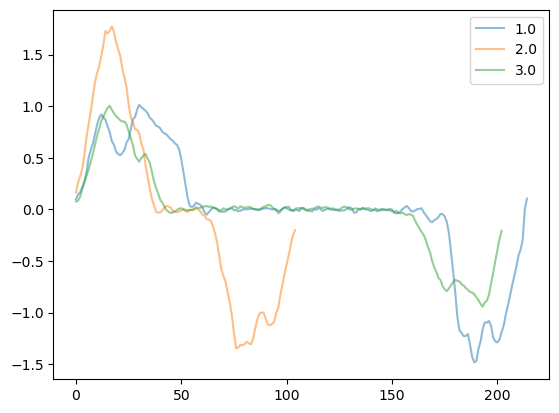

SNIPPET: 0


100%|██████████| 10/10 [00:00<00:00, 2620.29it/s]


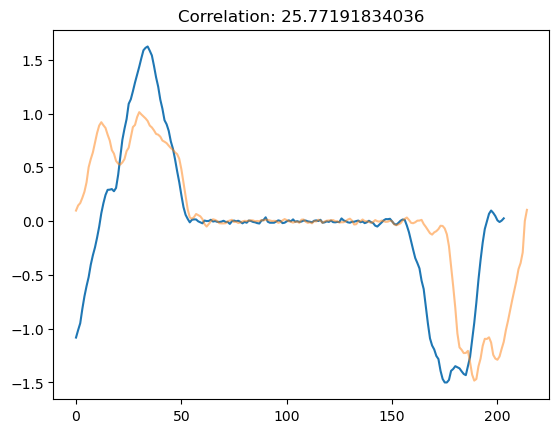

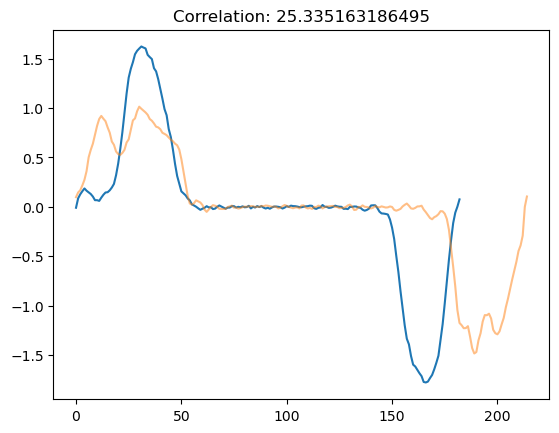

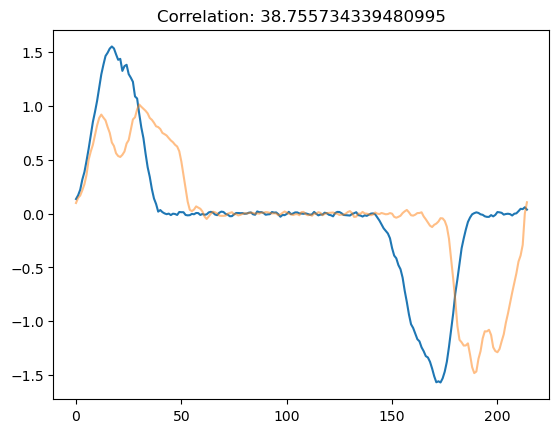

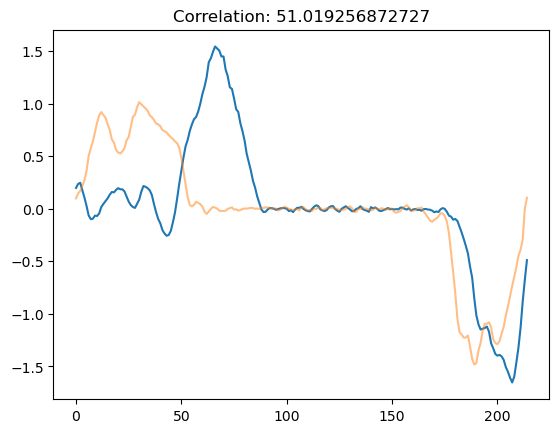

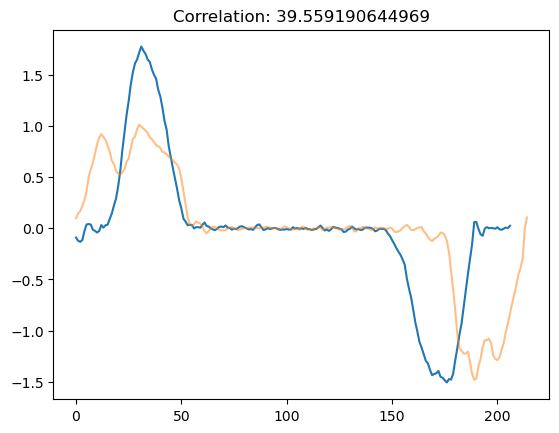

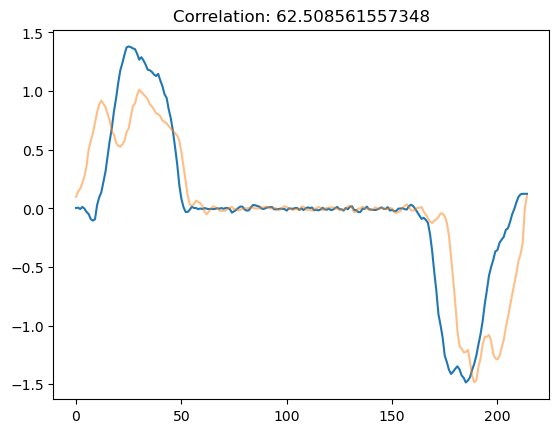

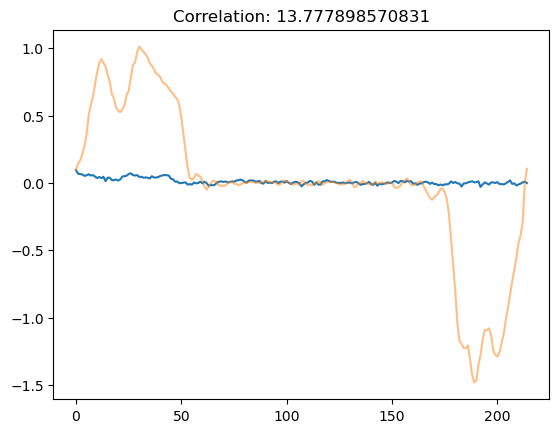

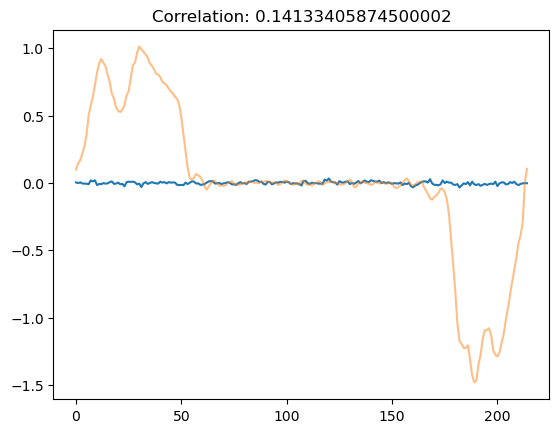

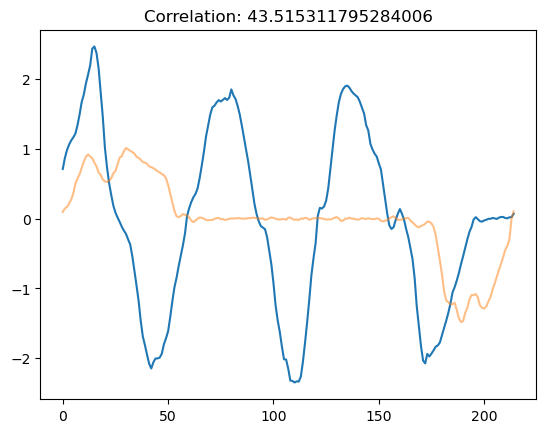

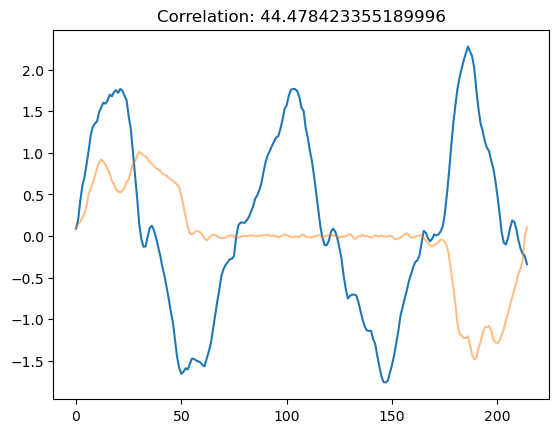

SNIPPET: 1


100%|██████████| 10/10 [00:00<00:00, 3745.92it/s]


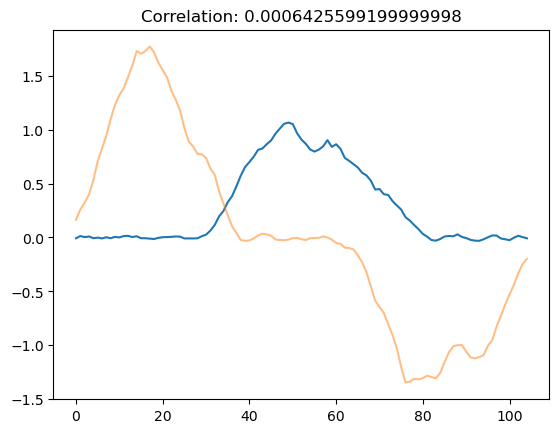

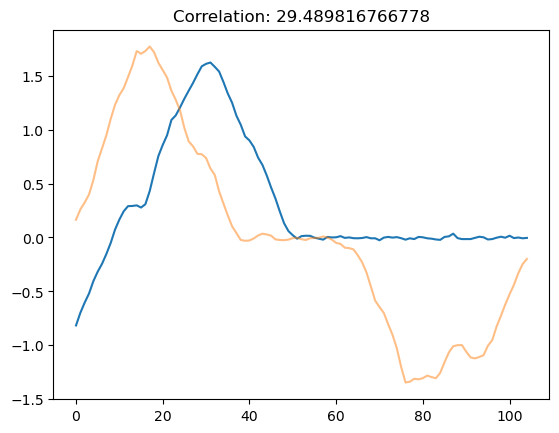

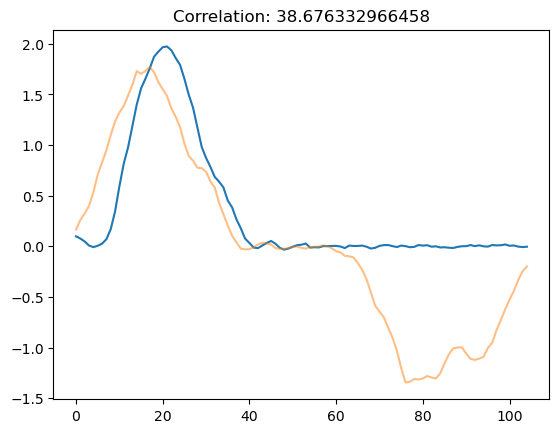

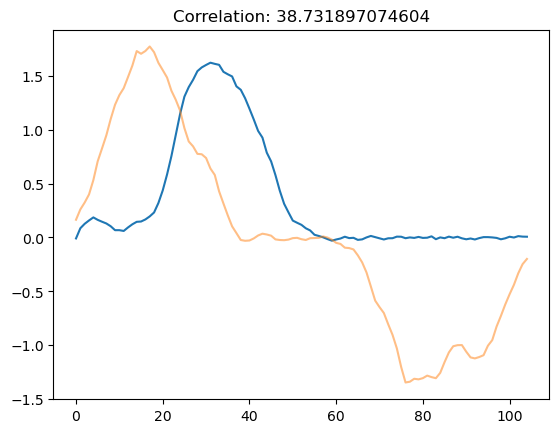

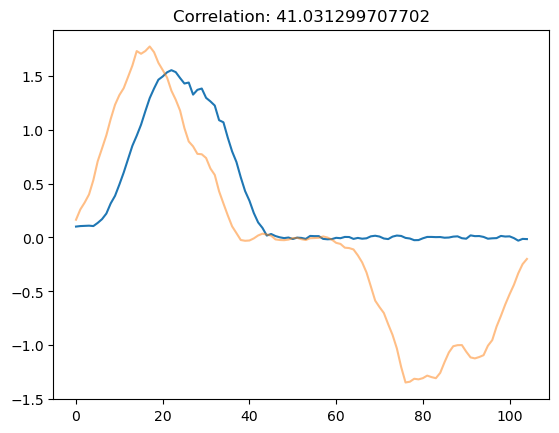

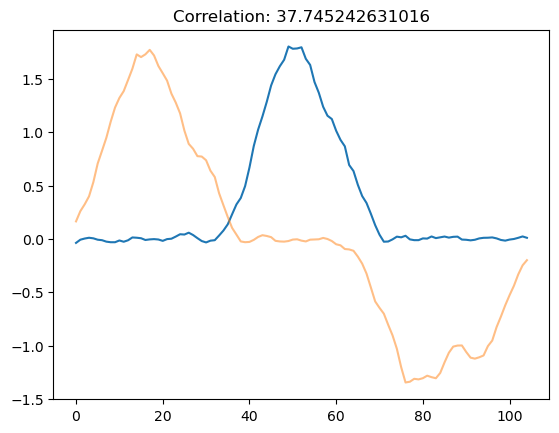

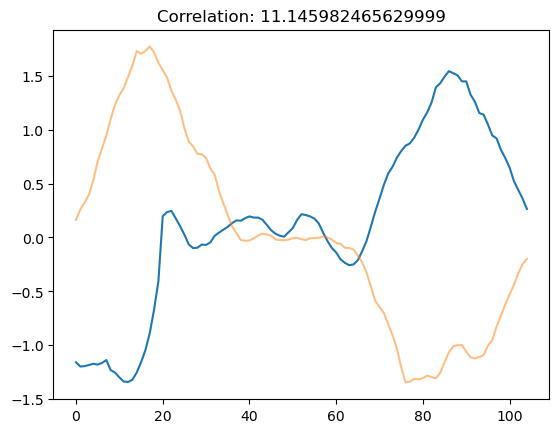

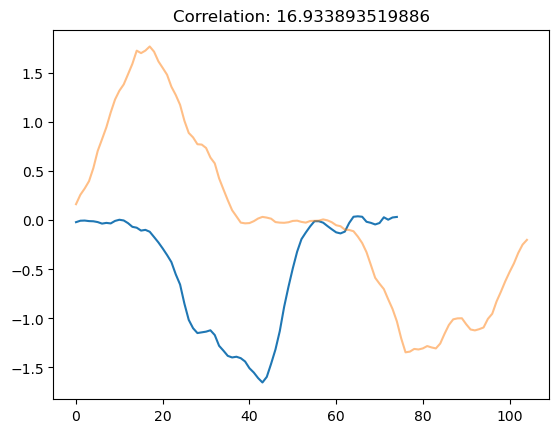

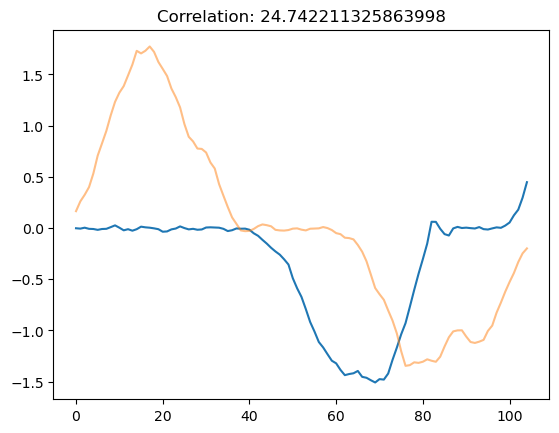

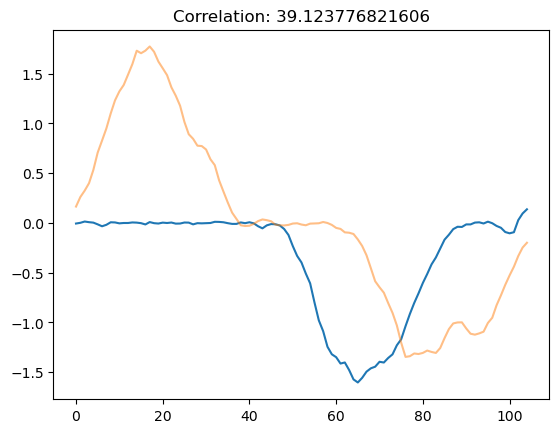

SNIPPET: 2


100%|██████████| 10/10 [00:00<00:00, 3115.20it/s]


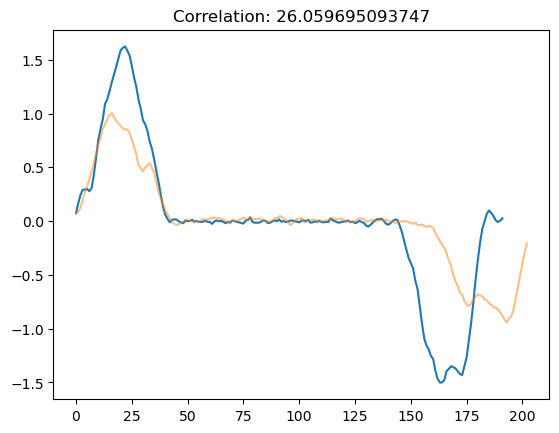

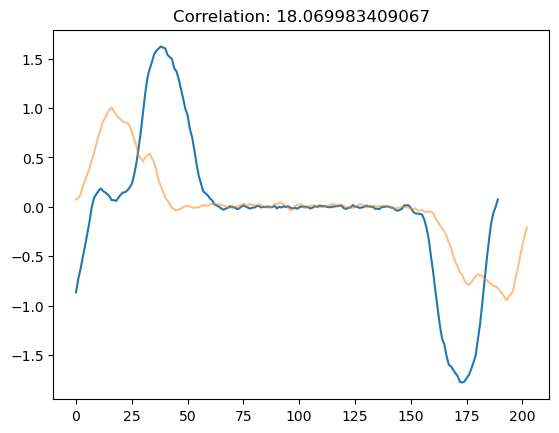

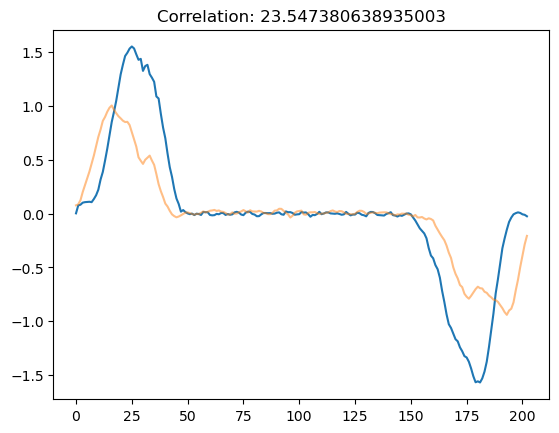

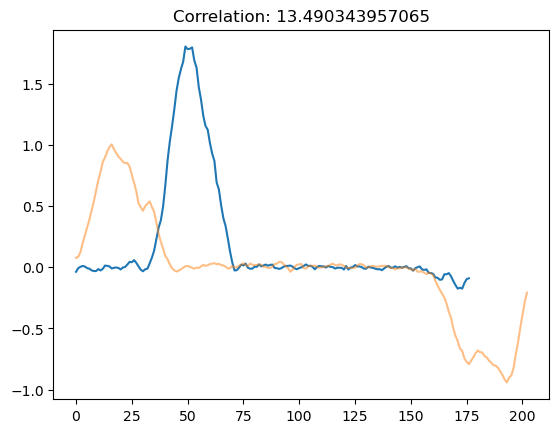

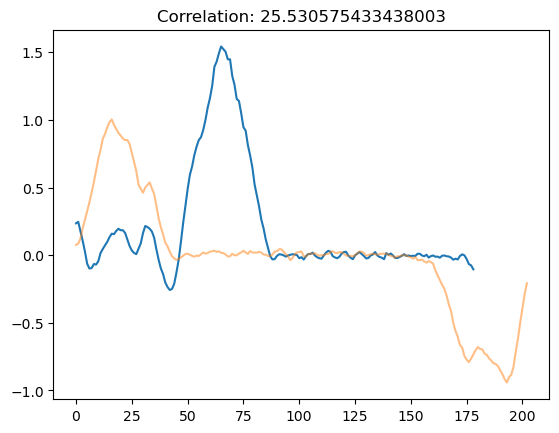

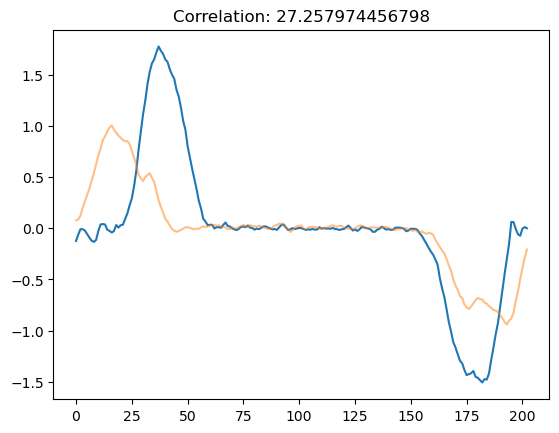

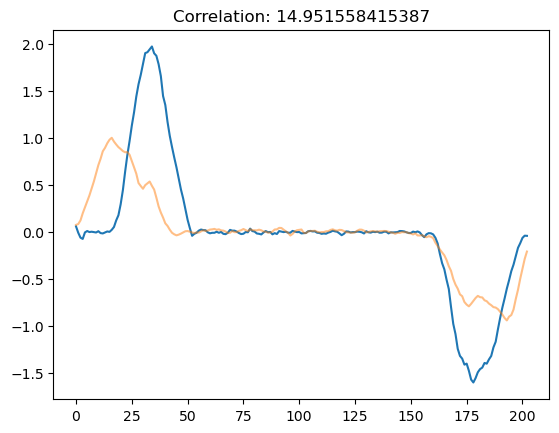

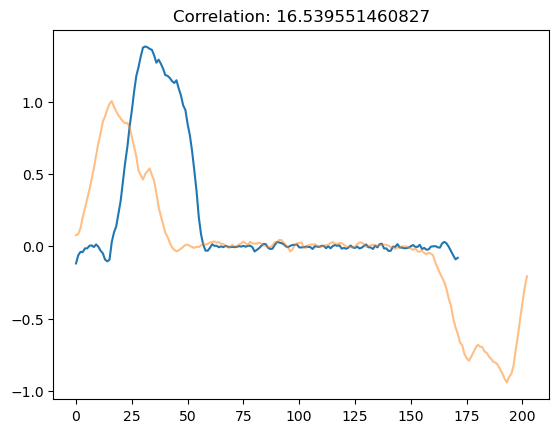

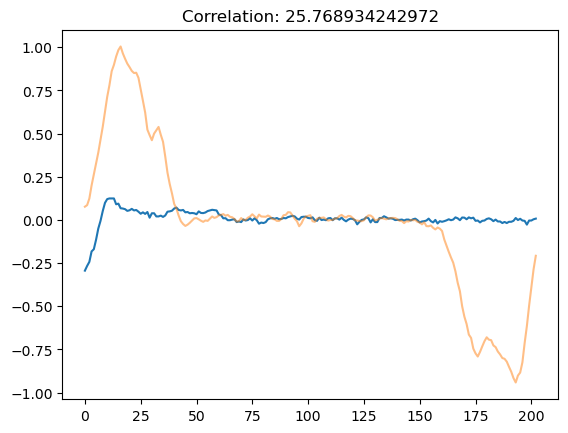

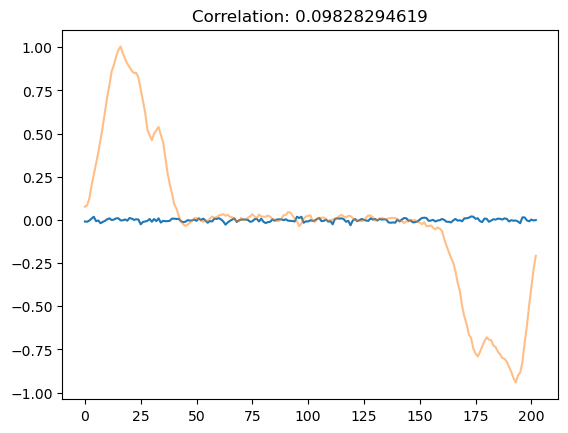

In [25]:
def extractPeriods(snippet : np.ndarray, data : np.ndarray, offset : int):
    """ Use correlation to extract individual periods from a whole time series.
        The time series is divided in 3 parts, where for each template there are 
        10 periods. Periods are extracted by assuming the highest correlation
        with the snippet.

        The idea is that we first perform the correlation, then we fine the maximum
        highest correlation point within the first len(snippet) values. This
        is done because the snippets also highly correlate with parts of the time-series
        throughout the whole data spectrum, not just its corresponding section within it.

        Since we're matching with a snippet fixed length but periods have a varied length,
        the extracted period ending is checked if it is above 0.5. If it is, then we 
        throw out the data until we get closer to 0.1. This is done because the correlation
        is not perfect and we want to get rid of the noise.

        Afterwards we append the extracted output, and move the data offset by 1/4th of the
        snippet length. This is done because the snippet is not perfectly aligned with the
        data, so we want to move it by a bit to get a better match.

        snippet: template that we match against
        data: the data to extract the snippet from
        offset: the offset in the data to start looking for the snippet
    """

    output = []
    sl = len(snippet)
    data = data[offset:]
    max_possible_samples = 10
    for _ in tqdm(range(max_possible_samples)):        
        c = correlate(data, snippet)
        l = len(snippet)

        # find the first highest value within the first len(snippet) values
        idx = np.argmax(c[:l])
        start = idx
        end = idx + len(snippet)
        waveform = data[start:end]

        # if waveform last value is higher than 0.1, then backtrack to the first index that is below 0.01
        if waveform[-1] > 0.5:
            for i in range(1, len(waveform)):
                if waveform[-i] < 0.1:
                    end = end - i
                    waveform = waveform[:-i]
                    break
        
        # if waveform last value is lower than -0.1, then backtrack to the first index that is above -0.01
        if waveform[-1] < -0.5:
            for i in range(1, len(waveform)):
                if waveform[-i] > -0.1:
                    end = end - i
                    waveform = waveform[:-i]
                    break

        output.append((waveform, c[idx]))
        end_offset = end - int(sl / 8) # move by 1/4th of the snippet length
        data = data[end_offset:]
    
    # Visualize output
    for (waveform, corr) in output:
        plt.plot(waveform)
        plt.plot(snippet, alpha=0.5)
        plt.title(f"Correlation: {corr}")
        plt.show()
        plt.close()
    
    # plot data and put markers on the start and end of each period
    return output[:10]
    

def extractSnippets(tt, template):
    """ TT contains three rows with start, end ranges that specify the snippets
        in the template
    """
    snippets = []
    for i in range(len(tt)):
        label = tt.iloc[i]['execution type']
        start = int(tt.iloc[i]['start'])
        end = int(tt.iloc[i]['end'])
        snippet = template[start:end]
        reset = snippet.reset_index()
        snippet["label"] = label
        snippets.append(reset)
        plt.plot(snippet["gyr_z"].values, alpha=0.5, label=label)

    plt.legend()
    plt.show()
    return snippets


for tt, test, ts in templateTimes.values():    
    tt = pd.read_csv(tt, sep=';')
    template = pd.read_csv(ts, sep=';')
    test = pd.read_csv(test, sep=';')

    # extract snippets
    dataOffset = 0
    snippets = extractSnippets(tt, template)
    for i, snippet in enumerate(snippets):
        # process snippet
        print(f"SNIPPET: {i}")

        s = snippet["gyr_z"]
        t = test["gyr_z"]
        periods = extractPeriods(s.values, t.values, dataOffset)
        dataOffset += sum([len(p) for p in periods])
    break


    



